In [114]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

import pandas as pd
import matplotlib.pyplot as plt

In [156]:
# sdata = pd.read_csv('data.csv', sep=';', encoding='cp866', parse_dates=[0]).fillna(0)
sdata = pd.read_csv('data.csv', sep=';', encoding='cp866').fillna(0)
sdata.info()
sdata.head(10)

# в одной из стран замечен значительный рост костов за трафик от абонентов двух (соседних) регионов
# изначально была выдвинута гипотеза, что это связано с covid (люди застряли в роуминге)

# данные обрезаны и упрощены для тестовых целей - мне тут важно было не столько найти причины,
# сколько потренироваться с графиками

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8706 entries, 0 to 8705
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   report_date  8706 non-null   object 
 1   branch       8706 non-null   object 
 2   subs_id      8706 non-null   int64  
 3   cnt_days     8706 non-null   int64  
 4   m            8706 non-null   float64
 5   m_chrg       8706 non-null   float64
 6   mb           8706 non-null   float64
 7   mb_chrg      8706 non-null   float64
 8   all_chrg     8706 non-null   float64
 9   rev          8706 non-null   float64
 10  tp_group     8706 non-null   object 
dtypes: float64(6), int64(2), object(3)
memory usage: 748.3+ KB


,report_date,branch,subs_id,cnt_days,m,m_chrg,mb,mb_chrg,all_chrg,rev,tp_group
0,2019-06-01,Регион1,100037900781,4,3.67,12.59,352.5,562.59,582.04,1524.87,Т2
1,2019-06-01,Регион1,100048774130,6,0.00,0.00,0.0,0.01,0.01,291.67,Т3
2,2019-06-01,Регион1,100034567775,1,0.00,0.00,0.0,0.00,0.00,338.33,Т2
3,2019-06-01,Регион1,100037923118,1,0.40,0.00,0.0,0.00,0.00,362.50,Т4
4,2019-06-01,Регион1,100034523456,1,0.00,0.00,0.0,0.00,0.00,250.00,T1
5,2019-06-01,Регион1,100054870913,2,5.23,0.00,3.2,4.40,4.40,2192.25,Т2
6,2019-06-01,Регион1,100063739375,2,0.00,0.00,0.0,0.00,0.00,291.67,Т3
7,2019-06-01,Регион1,100055783008,1,0.00,0.00,0.0,0.00,0.00,291.67,Т3
8,2019-06-01,Регион1,100065107214,2,0.00,0.00,0.0,0.03,0.03,0.00,Т3
9,2019-06-01,Регион1,100034648076,1,0.00,0.00,338.9,540.86,544.29,2737.50,Т2


Text(0, 0.5, 'rub')

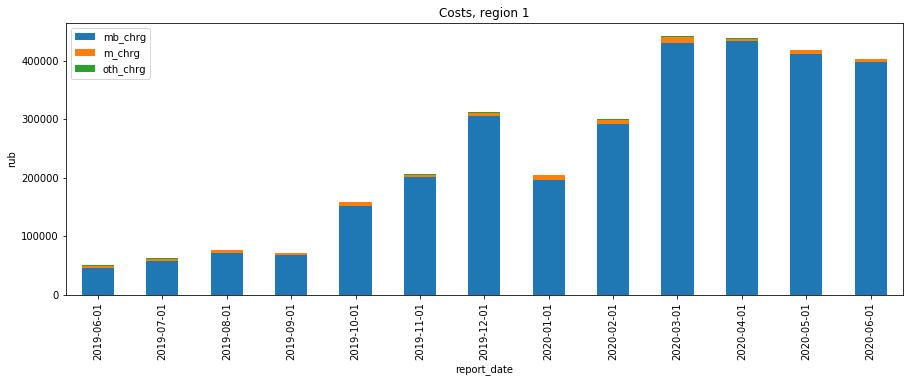

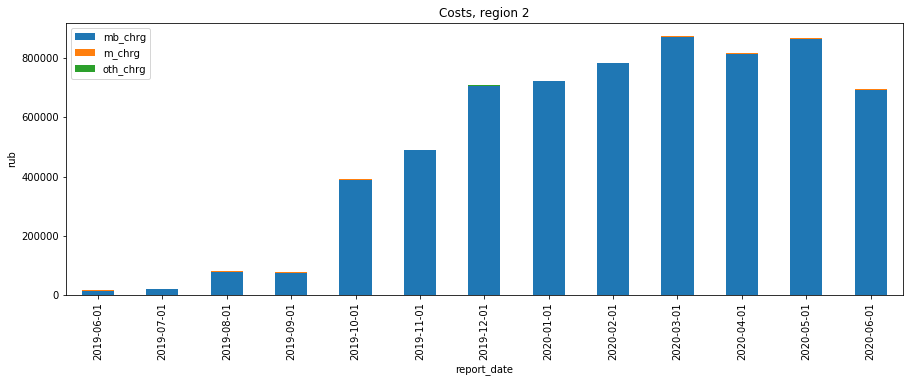

In [158]:
# для начала посмотрим, что нам генерит затраты
# поскольку данные непольные, добавим одно поле с прочими затратами
sdata['oth_chrg'] = sdata['all_chrg'] - sdata['mb_chrg'] - sdata['m_chrg']

# и посмотрим, что у нас по долям в регионах
r1=(
sdata[sdata.branch=='Регион1']
.groupby(['report_date']).sum()
[['mb_chrg', 'm_chrg','oth_chrg']]
.plot(kind='bar', stacked=True, title='Costs, region 1')
)
r1.set_xlabel('report_date') 
r1.set_ylabel('rub')

r2=(
sdata[sdata.branch=='Регион2']
.groupby(['report_date']).sum()
[['mb_chrg', 'm_chrg','oth_chrg']]
.plot(kind='bar', stacked=True, title='Costs, region 2')
)
r2.set_xlabel('report_date') 
r2.set_ylabel('rub')

# видно, что основную долю трафика занимает дата, причем рост начался не во время ковида, а много раньше (в октябре)
# гипотеза, соотв., что прирост расходов связан не (только) с ковид, т.к. начался раньше

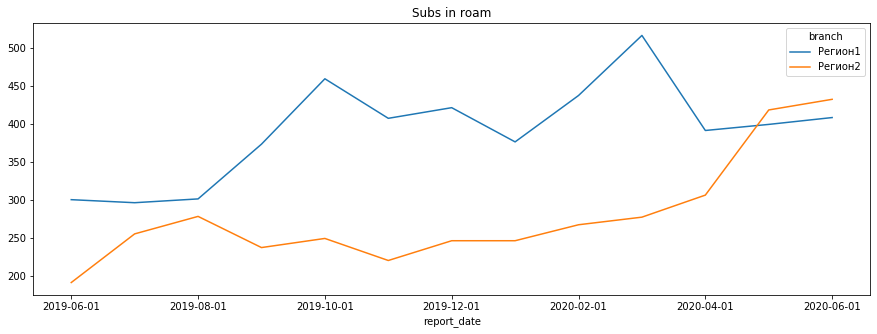

In [159]:
# может быть у нас выросло количество абонентов в роуминге?
sdata.groupby(['report_date', 'branch']).count().unstack('branch')['subs_id'].plot(kind='line', title='Subs in roam')
# да, наблюдается рост абонентов в регионе 1 с октября, хотя и не сопоставимый с ростом трафика.
# в то же время, в регионе 2 такой динамики по абоентам нет
# гипотеза - рост трафика/костов не связан напрямую с количеством абонентов. есть другие факторы

In [160]:
# а проверим-ка тарифы, например в июне
#  плюс построим бублик для июня регион2
(
sdata[(sdata.branch=='Регион2') & (sdata.report_date=='2020-06-01')]
.groupby(['tp_group']).sum()[['all_chrg', 'mb', ]]
.sort_values('all_chrg', ascending=False)
.style.bar()
)
# опаньки. основная доля расходов и трафика приходится на одну группу тарифов
# гипотеза - с ними и связан рост расходов. надо посмотреть динамику

,all_chrg,mb
tp_group,,
Т5,681450.920000,387334.500000
Т3,9532.870000,4984.100000
Т2,3259.770000,1538.800000
Т4,1715.930000,868.400000
other,1134.580000,599.000000
T1,89.910000,3.800000


Text(0, 0.5, 'rub')

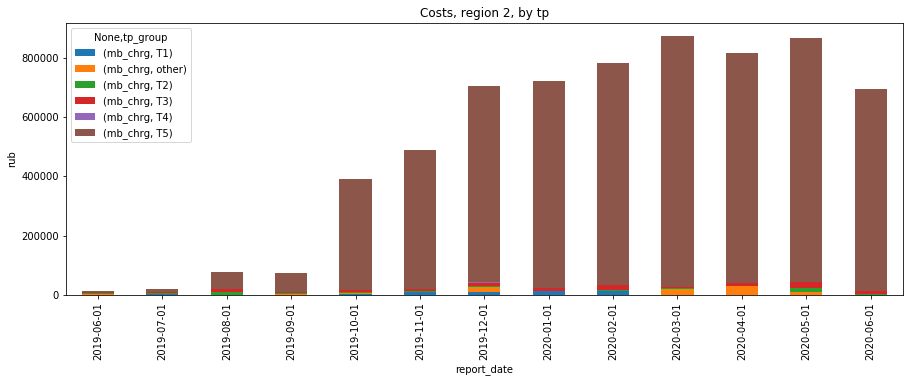

In [161]:
# посмотрим в динамике
(
sdata[sdata.branch=='Регион2']
.groupby(['report_date', 'tp_group']).sum()
.unstack('tp_group')
[['mb_chrg']]
.plot(kind='bar', stacked=True, title='Costs, region 2, by tp')
.set_ylabel('rub') 
)

In [162]:
import seaborn as sns

Text(0.5, 1, 'Days in roam, all TP')

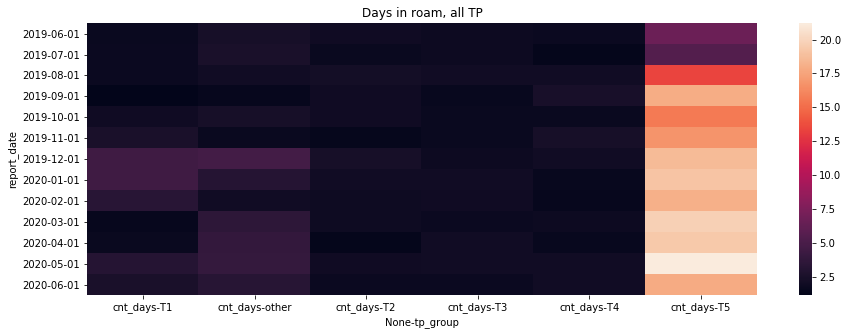

In [163]:
# построим тепловую карту по среднему количеству дней в роуминге по месяцам
rdata=(
sdata[(sdata.branch=='Регион2')]
.groupby(['report_date', 'tp_group']).mean()
.unstack('tp_group')
[['cnt_days']]
)
sns.heatmap(rdata).set_title('Days in roam, all TP')
# видно значительный перекос по ср-му кол-ву дней в роуминг у T5
# причем рост начался с августа, то есть даже раньше, чем начался активный рост трафика (с октября)
# гипотеза - свойства T5 могут использоваться для фрода. Причем, тариф изначально заточен под роуминг,
# но в августе и октябре произошли какие-то изменения, повлиявшие на рост трафика

Text(0.5, 1.0, 'Days in roam, T5, 06.2020')

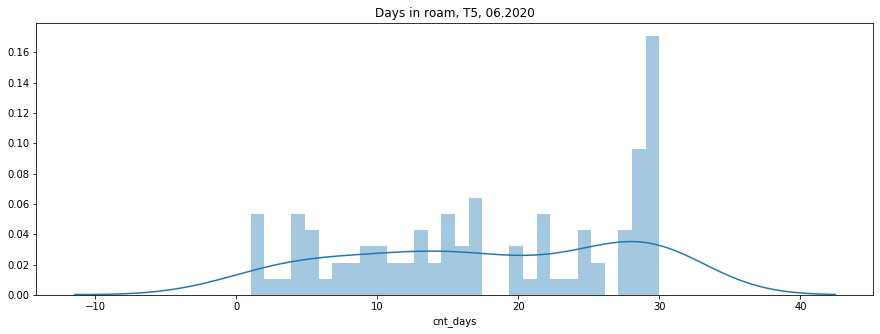

In [164]:
# напоследок, можно посмотреть сколько в среднем проводили абоненты TP5 дней в роуминге в июнеч
# тобы понять распределение по группам возможных фродеров и "честных" абонентов
rdata=(
sdata[(sdata.branch=='Регион2') & (sdata.tp_group=='Т5') & (sdata.report_date=='2020-06-01') ]
[['cnt_days']]
)

sns.distplot(rdata.cnt_days, bins=30).set_title('Days in roam, T5, 06.2020')
# виден довольно серьезный выброс в районе 30 дней - т.е. значительная часть абонентов пользуется данными в течение всего месяца
# гипотеза - свойства T5 могу использоваться для фрода

In [ ]:
#  ну и т.д.